# Stitching Images and Making ChatGPT vision request

## 1. Stitching Images

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

### 1.1 Set Image Paths

In [12]:
image1_path = "notebooks/0a1dc797-7531-4494-afe6-add6ac3f74c0.jpg"
bar_entry_path = "notebooks/4c045f20-353f-4e65-a770-dd4e2a7668c8.jpg"
output_file = 'stitched_output.jpg'

### 1.2 Loading Images

In [13]:
# Read the two images using OpenCV (ensure both images are of the same size)
image1 = cv2.imread(image1_path)
image2 = cv2.imread(bar_entry_path)


In [20]:
# Convert images from BGR to RGB (since OpenCV loads images in BGR format)
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)


### 1.3 Stitching Images

In [21]:
# Horizontal stitching
stitched_image_horizontal = np.hstack((image1, image2))

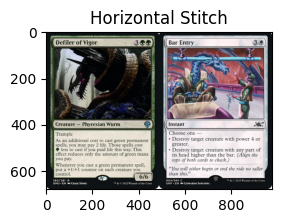

In [22]:
# Display the stitched images
plt.subplot(1, 2, 1)
plt.imshow(stitched_image_horizontal)
plt.title('Horizontal Stitch')
plt.show()

In [23]:
# Convert the stitched image back to BGR for saving with OpenCV
stitched_image_bgr = cv2.cvtColor(stitched_image_horizontal, cv2.COLOR_RGB2BGR)

# Save the stitched image as a file
cv2.imwrite(output_file, stitched_image_horizontal)

True

## 2. ChatGPT API Request Sample

### 2.1 Prompt

In [48]:
# Construct your message
creature_type = "Phyrexian Wurm"
prompt = "The First half of the image (horizontally) is a mtg creature card. It is a {}. The second half of the image is a card called bar entry with the following text: {} and rules text: {} {} {} {}. Answer this question: Given that two cards aligned in this image. Is the first card under the bar? Please provide a single one-word answer: Yes, No, or Ambiguous"
oracle_text = """
Choose one —
Destroy target creature with power 4 or greater.
Destroy target creature with any part of its head higher than the bar. (Align the tops of both cards to check.)
"""
rules_text_1 = " if you had a ruler, the top of both cards would be lined up against it. If any part of that creature's head is higher than the bottom of the bar (that is, if it would hit the bar), the creature is a legal target. "
rules_text_2 = "If there are multiple creatures in the art, only compare the one that represents the actual creature on the card. For example, Tarmogoyf (MMA) has the tarmogoyf itself and an elk in the art, and you need only consider the tarmogoyf. "
rules_text_3 = " If there are multiple creatures in the art that each match what the card is representing, then you can target that creature if any of them has any part of its head higher than the bar. For example, Llanowar Elves (M19) has three figures in its art, all of whom are Llanowar elves. The creature can be destroyed if any of those elves has a part of their head higher "
rules_text_4 = "  Only a creature's head counts. Other body parts (such as tails) being above the bar doesn't make a creature a legal target. If a creature is wearing a hat on its head, treat the hat as part of its head. "
formatted_prompt = prompt.format(creature_type, oracle_text, rules_text_1, rules_text_2, rules_text_3, rules_text_4)

In [49]:
print(formatted_prompt)

The First half of the image (horizontally) is a mtg creature card. It is a Phyrexian Wurm. The second half of the image is a card called bar entry with the following text: 
Choose one —
Destroy target creature with power 4 or greater.
Destroy target creature with any part of its head higher than the bar. (Align the tops of both cards to check.)
 and rules text:  if you had a ruler, the top of both cards would be lined up against it. If any part of that creature's head is higher than the bottom of the bar (that is, if it would hit the bar), the creature is a legal target.  If there are multiple creatures in the art, only compare the one that represents the actual creature on the card. For example, Tarmogoyf (MMA) has the tarmogoyf itself and an elk in the art, and you need only consider the tarmogoyf.   If there are multiple creatures in the art that each match what the card is representing, then you can target that creature if any of them has any part of its head higher than the bar. F

### 2.2 Encoding Image

In [50]:
from openai import OpenAI
from dotenv import load_dotenv
load_dotenv()  # take environment variables from .env.
import base64
import os
import requests

In [51]:

# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')


### 2.3 Request

In [52]:
# Path to your image
image_path = "stitched_output.jpg"

# Getting the base64 string
base64_image = encode_image(image_path)

api_key = os.environ["OPENAI_API_KEY"]
headers = {
  "Content-Type": "application/json",
  "Authorization": f"Bearer {api_key}"
}

payload = {
  "model": "gpt-4o-mini",
  "messages": [
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": formatted_prompt
        },
        {
          "type": "image_url",
          "image_url": {
            "url": f"data:image/jpeg;base64,{base64_image}"
          }
        }
      ]
    }
  ],
  "max_tokens": 300
}



### 2.4 Response

In [53]:
response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)


In [55]:
response.json()['choices'][0]['message']

{'role': 'assistant', 'content': 'No', 'refusal': None}

## 3. Processing Scryfall Data

### 3.1 Set Params and Input/Output Files

In [164]:
date_start = '2003-01-01'
date_end = '2024-01-01'
raw_data_file = 'metadata/oracle-cards-20240328090146.json'
filtered_file = 'metadata/oracle-cards-filtered-post-2003_v2.json'
extracted_data = 'metadata/oracle-cards-extracted_columns_v2.json'
set_types = ['masters', 'expansion', 'core', 'commander']
columns_to_extract = ["oracle_id", "name", "type_line", "oracle_text", "artist","scryfall_uri", "artist_ids", "png", "small", "large", "normal", "art_crop", "border_crop"]

### 3.2 Filtering Cards

#### 3.2.1 Filters

In [57]:
import pandas as pd

In [172]:
raw_df = pd.read_json(raw_data_file)
rslt_df = raw_df[raw_df['type_line'].str.contains("creature", case=False)] 
rslt_df = rslt_df[rslt_df['set_type'].isin(set_types)]
rslt_df = rslt_df.loc[(rslt_df['released_at'] >= date_start) & (rslt_df['released_at'] <= date_end)]
rslt_df = rslt_df.loc[~rslt_df['layout'].str.contains('transform')]
rslt_df = rslt_df[rslt_df['image_uris'].notnull()]

#### 3.2.2 Normalizing Url Column

In [185]:
# Normalize the 'info' column
info_normalized = pd.json_normalize(rslt_df['image_uris']).reset_index(drop=True)

# Reset the index of the original DataFrame
original_df = rslt_df.drop(columns=['image_uris']).reset_index(drop=True)

# Concatenate the normalized columns back to the original dataframe
rslt_df_final = pd.concat([original_df, info_normalized], axis=1)

#### 3.2.3 Writing Filtered df to File

In [187]:
rslt_df_final.to_json(filtered_file, orient='records', lines=True)

### 3.3 Column Selection

#### 3.3.1 Reading File and Selecting Columns

In [188]:
df_filtered = pd.read_json(filtered_file, lines=True)
df_filtered = df_filtered[columns_to_extract]

#### 3.3.2 Writing df to file

In [ ]:
df_filtered.to_json(extracted_data, orient='records', lines=True)

## 4. More OpenAI Experimentation

In [101]:
import pandas as pd

from openai import OpenAI
from dotenv import load_dotenv
import base64
import os
import requests
import cv2
import numpy as np
import matplotlib.pyplot as plt

load_dotenv()  # take environment variables from .env.


True

In [129]:
# I have two directories with images pulled from the scryfall api. One is called images (745x1040). one is called imagesNormal (488x680)

images_dir = "../imagesNormal"
file_type = ".jpg"
extracted_data = '../metadata/oracle-cards-extracted_columns_v2.json'
labeled_data = '../metadata/cards_with_labels.json'

In [38]:
def generatePrompt(creature_type):
    # Construct your message
    prompt = "The First half of the image (horizontally) is a mtg creature card. It is a {}. The second half of the image is a card called bar entry with the following text: {} and rules text: {} {} {} {}. Answer this question: Given that two cards aligned in this image. Is the first card under the bar? Please provide a single one-word answer: Yes, No, or Ambiguous"
    oracle_text = """
    Choose one —
    Destroy target creature with power 4 or greater.
    Destroy target creature with any part of its head higher than the bar. (Align the tops of both cards to check.)
    """
    rules_text_1 = " if you had a ruler, the top of both cards would be lined up against it. If any part of that creature's head is higher than the bottom of the bar (that is, if it would hit the bar), the creature is a legal target. "
    rules_text_2 = "If there are multiple creatures in the art, only compare the one that represents the actual creature on the card. For example, Tarmogoyf (MMA) has the tarmogoyf itself and an elk in the art, and you need only consider the tarmogoyf. "
    rules_text_3 = " If there are multiple creatures in the art that each match what the card is representing, then you can target that creature if any of them has any part of its head higher than the bar. For example, Llanowar Elves (M19) has three figures in its art, all of whom are Llanowar elves. The creature can be destroyed if any of those elves has a part of their head higher "
    rules_text_4 = "  Only a creature's head counts. Other body parts (such as tails) being above the bar doesn't make a creature a legal target. If a creature is wearing a hat on its head, treat the hat as part of its head. "
    formatted_prompt = prompt.format(creature_type, oracle_text, rules_text_1, rules_text_2, rules_text_3, rules_text_4)
    return formatted_prompt

In [39]:
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

In [111]:
# def stitchImages(image1_path, bar_entry_path, output_file):
#     # Read the two images using OpenCV (ensure both images are of the same size)
#     image1 = cv2.imread(image1_path)
#     image2 = cv2.imread(bar_entry_path)
    
#     # Convert images from BGR to RGB (since OpenCV loads images in BGR format)
#     image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
#     image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
    
#     # Horizontal stitching
#     stitched_image_horizontal = np.hstack((image1, image2))
    
#     # Convert the stitched image back to BGR for saving with OpenCV
#     stitched_image_bgr = cv2.cvtColor(stitched_image_horizontal, cv2.COLOR_RGB2BGR)

#     # Save the stitched image as a file
#     cv2.imwrite(output_file, stitched_image_horizontal)

In [114]:
def stitchImages(image1_path, bar_entry_path, output_file):
    # Read the two images using OpenCV (ensure both images are of the same size)
    image1 = cv2.imread(image1_path)
    image2 = cv2.imread(bar_entry_path)
    
    # Stitch the images horizontally
    stitched_image = cv2.hconcat([image1, image2])
    
    # Save the stitched image to a file
    cv2.imwrite(output_file, stitched_image)

In [115]:
def chatGPTRequestWithImage(prompt, image_path):
    # Getting the base64 string
    base64_image = encode_image(image_path)
    
    api_key = os.environ["OPENAI_API_KEY"]
    headers = {
      "Content-Type": "application/json",
      "Authorization": f"Bearer {api_key}"
    }
    payload = {
      "model": "gpt-4o-mini",
      "messages": [
        {
          "role": "user",
          "content": [
              {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image}"
              }
            },
            {
              "type": "text",
              "text": prompt
            },
            
          ]
        }
      ],
      "max_tokens": 300
    }
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    return response


In [116]:
def sampleTwentyCards(df):
    sampled_df = df.sample(n=20, random_state=42)
    return sampled_df

In [117]:
df = pd.read_json(extracted_data, lines=True)
cards = sampleTwentyCards(df)
card_ids = cards['oracle_id'].tolist()

In [118]:
card_images = list(map(lambda x: os.path.join(images_dir, x + file_type), card_ids))

In [120]:
image_path = card_images[0]
bar_entry_path = "4c045f20-353f-4e65-a770-dd4e2a7668c8.jpg"
output_file = 'stitched_output.jpg'

In [123]:
stitchImages(image_path, bar_entry_path, output_file)

In [125]:
prompt = generatePrompt(cards['type_line'].iloc[0])

In [105]:
response = chatGPTRequestWithImage(prompt, output_file) 

In [106]:
response.json()['choices'][0]['message']

{'role': 'assistant', 'content': 'Yes', 'refusal': None}

In [130]:
cards['barEntryLabel'] = 'No'
bar_entry_path = "4c045f20-353f-4e65-a770-dd4e2a7668c8.jpg"
output_file = 'stitched_output.jpg'

In [132]:
responses = []

In [133]:
for i in range(len(card_images)):
    image_path = card_images[0]
    cards['type_line'].iloc[i]
    stitchImages(image_path, bar_entry_path, output_file)
    prompt = generatePrompt(cards['type_line'].iloc[i])
    response = chatGPTRequestWithImage(prompt, output_file) 
    responses.append(response)
    cards.loc[cards['oracle_id'] == card_ids[i], 'barEntryLabel'] = response.json()['choices'][0]['message']['content']

In [135]:
cards[['oracle_id', 'normal', 'barEntryLabel']]

,oracle_id,normal,barEntryLabel
119,02abe85a-c603-4963-aba4-524cc80847ea,https://cards.scryfall.io/normal/front/5/d/5d1...,No
8771,dc3073fc-dc23-426e-b867-fee5dd99fe25,https://cards.scryfall.io/normal/front/8/5/85c...,Yes
3609,5adcd0cb-9305-4e77-a117-31e9dca5c96d,https://cards.scryfall.io/normal/front/2/7/277...,Ambiguous
1923,301b8265-9e17-48c3-942d-b7243112b394,https://cards.scryfall.io/normal/front/9/d/9d7...,No
3064,4c5a2443-a038-44d3-83a4-5e9a6db7b1a7,https://cards.scryfall.io/normal/front/b/b/bb9...,No
4505,713bcfb6-e5ea-411e-b4b3-52e5eed5cdf1,https://cards.scryfall.io/normal/front/4/d/4df...,Yes
4453,703215df-dee2-4b82-9f32-256e1410543c,https://cards.scryfall.io/normal/front/7/e/7e2...,Yes
1606,2764741c-1f3e-459a-a487-54cbac2c84a6,https://cards.scryfall.io/normal/front/d/d/ddf...,Ambiguous
33,00d11662-9d10-4915-b80c-c1ad54b4e71b,https://cards.scryfall.io/normal/front/f/1/f10...,No
6973,afc3a65e-7a7a-4bd9-bca4-aa762b9bbbcb,https://cards.scryfall.io/normal/front/7/1/712...,No


In [136]:
cards.to_json(labeled_data, orient='records', lines=True)

In [ ]:
card_images = list(map(lambda x: os.path.join(images_dir, x + file_type), card_ids))
for i in range(len(card_images)):
    image_path = card_images[0]
    cards['type_line'].iloc[i]
    stitchImages(image_path, bar_entry_path, output_file)
    prompt = generatePrompt(cards['type_line'].iloc[i])
    response = chatGPTRequestWithImage(prompt, output_file) 
    responses.append(response)
    cards.loc[cards['oracle_id'] == card_ids[i], 'barEntryLabel'] = response.json()['choices'][0]['message']['content']

## 5. Batch Processsing